This Lab is a compilation of [https://d2l.ai/d2l-en.pdf](https://d2l.ai/d2l-en.pdf) materials, relataed to RNN networks.
Please refer to it as original

# Recurrent Neural Networks

So far we encountered two types of data: tabular data and image data.
For the latter we designed specialized layers to take advantage of the regularity in them.
In other words, if we were to permute the pixels in an image, it would be much more difficult to reason about its content of something that would look much like the background of a test pattern in the times of analog TV.

Most importantly, so far we tacitly assumed that our data are all drawn from some distribution,
and all the examples are independently and identically distributed (i.i.d.).
Unfortunately, this is not true for most data. For instance, the words in this paragraph are written in sequence, and it would be quite difficult to decipher its meaning if they were permuted randomly.
Likewise, image frames in a video, the audio signal in a conversation, and the browsing behavior on a website, all follow sequential order.
It is thus reasonable to assume that specialized models for such data will do better at describing them.

Another issue arises from the fact that we might not only receive a sequence as an input but rather might be expected to continue the sequence.
For instance, the task could be to continue the series $2, 4, 6, 8, 10, \ldots$ This is quite common in time series analysis, to predict the stock market, the fever curve of a patient, or the acceleration needed for a race car. Again we want to have models that can handle such data.

In short, while CNNs can efficiently process spatial information, *recurrent neural networks* (RNNs) are designed to better handle sequential information.
RNNs introduce state variables to store past information, together with the current inputs, to determine the current outputs.

Many of the examples for using recurrent networks are based on text data. Hence, we will emphasize language models in this chapter. After a more formal review of sequence data we introduce practical techniques for preprocessing text data.
Next, we discuss basic concepts of a language model and use this discussion as the inspiration for the design of RNNs.

## Sequences: a simple MLP

We generate sequence data by using a sine function with some additive noise for time steps $1, 2, \ldots, 1000$.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

In [2]:
T = 1000  # Generate a total of 1000 points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))

(1.0, 1000.0)

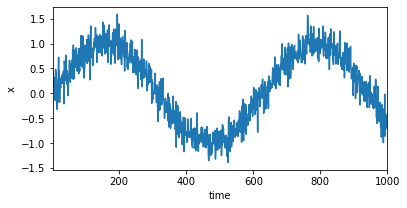

In [8]:
# Lets plot the data to see it:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(time, x)
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])

Next, we need to turn such a sequence into features and labels that our model can train on.
Based on the embedding dimension $\tau$ we [**map the data into pairs $y_t = x_t$ and $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]
The astute reader might have noticed that this gives us $\tau$ fewer data examples, since we do not have sufficient history for the first $\tau$ of them.
A simple fix, in particular if the sequence is long,
is to discard those few terms.
Alternatively we could pad the sequence with zeros.
Here we only use the first 600 feature-label pairs for training.

In [38]:
tau = 4
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [39]:
batch_size, n_train = 16, 600

# Only the first `n_train` examples are used for training
dataset = gluon.data.ArrayDataset(features[:n_train], labels[:n_train])
train_loader = gluon.data.DataLoader(dataset, batch_size, shuffle=True)

Here we [**keep the architecture fairly simple:
just an MLP**] with two fully-connected layers, ReLU activation, and squared loss.

In [42]:
# A simple MLP
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Square loss
loss = gluon.loss.L2Loss()

### Train

Now we are ready to [train the model].

In [51]:
history = []

def train(net, train_loader, loss, epochs, lr):

    trainer = gluon.Trainer(
        params = net.collect_params(),
        optimizer = 'adam',
        optimizer_params = {'learning_rate': lr}
    )

    for epoch in range(epochs):
        for X, y in train_loader:

            with autograd.record():
                out = net(X)
                l = loss(out, y)
                history.append(sum(l)/len(l))

            l.backward()
            trainer.step(batch_size)

        print('.', end='')

net = get_net()
train(net, train_loader, loss, 5, 0.01)

.....

Text(0.5, 0, 'Iteration')

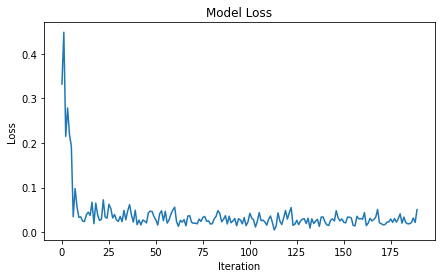

In [52]:
plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')

### Prediction

Since the training loss is small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to [predict what happens just in the next time step], namely the one-step-ahead prediction.

In [62]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(6, 3), axes=None):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    #plt.figure(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

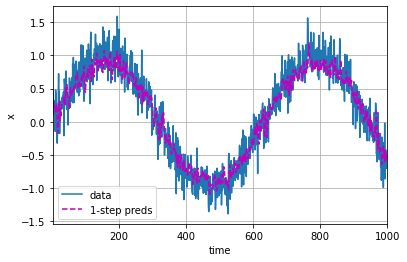

In [63]:
onestep_preds = net(features)

plot([time, time[tau:]], [x.asnumpy(), onestep_preds.asnumpy()], 'time',
      'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

The one-step-ahead predictions look nice, just as we expected.
Even beyond 604 (`n_train + tau`) observations the predictions still look trustworthy.
However, there is just one little problem to this:
if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions.
Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence up to $x_t$, its predicted output $\hat{x}_{t+k}$ at time step $t+k$ is called the $k$*-step-ahead prediction*. Since we have observed up to $x_{604}$, its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to [**use our own predictions to make multistep-ahead predictions**].
Let us see how well this goes.

In [64]:
multistep_preds = np.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

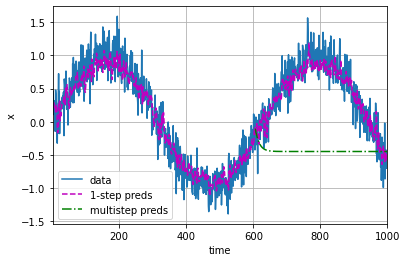

In [65]:
plot([time, time[tau:], time[n_train + tau:]],
         [x.asnumpy(), onestep_preds.asnumpy(),
          multistep_preds[n_train + tau:].asnumpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps.
Why did the algorithm work so poorly?
This is ultimately due to the fact that the errors build up.
Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + c \epsilon_1$ for some constant $c$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.

In [66]:
max_steps = 64

In [67]:
features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

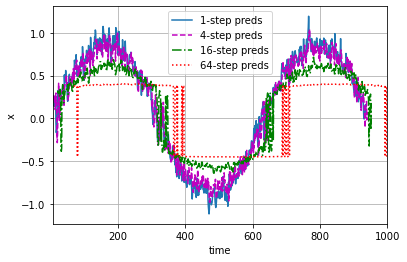

In [68]:
steps = (1, 4, 16, 64)
plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].asnumpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future.
While the 4-step-ahead predictions still look good, anything beyond that is almost useless.


### Summary

* There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a sequence, always respect the temporal order of the data when training, i.e., never train on future data.
* Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.
* For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.
* For an observed sequence up to time step $t$, its predicted output at time step $t+k$ is the $k$*-step-ahead prediction*. As we predict further in time by increasing $k$, the errors accumulate and the quality of the prediction degrades, often dramatically.


### Exercises

1. Improve the model in the experiment of this section.
    1. Incorporate more than the past 4 observations? How many do you really need?
    1. How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    1. Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?
    1. Change the neural network architecture and evaluate the performance.
1. An investor wants to find a good security to buy. He looks at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?
1. Does causality also apply to text? To which extent?
1. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.

## Text Processing

We have reviewed and evaluated statistical tools and prediction challenges for sequence data.
Such data can take many forms.

Specifically, as we will focus on in many chapters of the book, text is one of the most popular examples of sequence data. For example, an article can be simply viewed as a sequence of words, or even a sequence of characters. To facilitate our future experiments with sequence data, we will dedicate this section to explain common preprocessing steps for text.

Usually, these steps are:

1. Load text as strings into memory.
1. Split strings into tokens (e.g., words and characters).
1. Build a table of vocabulary to map the split tokens to numerical indices.
1. Convert text into sequences of numerical indices so they can be manipulated by models easily.

In [69]:
import collections
import re

### Reading the Dataset

To get started we load text from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35).
This is a fairly small corpus of just over 30000 words, but for the purpose of what we want to illustrate this is just fine.
More realistic document collections contain many billions of words.
The following function (**reads the dataset into a list of text lines**), where each line is a string.
For simplicity, here we ignore punctuation and capitalization.

In [75]:
def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open('data/time-machine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3557
the project gutenberg ebook of the time machine by h g wells
title the time machine


### Tokenization

The following `tokenize` function takes a list (`lines`) as the input, where each element is a text sequence (e.g., a text line).

[**Each text sequence is split into a list of tokens**].

A *token* is the basic unit in text.
In the end, a list of token lists are returned, where each token is a string.

In [76]:
def tokenize(lines, token='word'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
['this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and']
['most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions']
['whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms']
['of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at']
['www', 'gutenberg', 'org', 'if', 'you', 'are', 'not', 'located', 'in', 'the', 'united', 'states', 'you']
['will', 'have', 'to', 'check', 'the', 'laws', 'of', 'the', 'country', 'where', 'you', 'are', 'located', 'before']
['using', 'this', 'ebook']
[]
['title', 'the', 'time', 'machine']


### Vocabulary

The string type of the token is inconvenient to be used by models, which take numerical inputs.
Now let us [**build a dictionary, often called *vocabulary* as well, to map string tokens into numerical indices starting from 0**].
To do so, we first count the unique tokens in all the documents from the training set,
namely a *corpus*,
and then assign a numerical index to each unique token according to its frequency.
Rarely appeared tokens are often removed to reduce the complexity.
Any token that does not exist in the corpus or has been removed is mapped into a special unknown token “&lt;unk&gt;”.
We optionally add a list of reserved tokens, such as
“&lt;pad&gt;” for padding,
“&lt;bos&gt;” to present the beginning for a sequence, and “&lt;eos&gt;” for the end of a sequence.

In [77]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

We [**construct a vocabulary**] using the time machine dataset as the corpus.
Then we print the first few frequent tokens with their indices.

In [78]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('and', 2), ('of', 3), ('i', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('that', 9)]


Now we can (**convert each text line into a list of numerical indices**).


In [79]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 53, 44, 314, 3, 1, 19, 46, 33, 1163, 1164, 360]
words: ['title', 'the', 'time', 'machine']
indices: [2445, 1, 19, 46]


### Putting All Things Together

Using the above functions, we [**package everything into the `load_corpus_time_machine` function**], which returns `corpus`, a list of token indices, and `vocab`, the vocabulary of the time machine corpus.
The modifications we did here are:
(i) we tokenize text into characters, not words, to simplify the training in later sections;
(ii) `corpus` is a single list, not a list of token lists, since each text line in the time machine dataset is not necessarily a sentence or a paragraph.

In [80]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(189663, 28)

### Summary

* Text is an important form of sequence data.
* To preprocess text, we usually split text into tokens, build a vocabulary to map token strings into numerical indices, and convert text data into token indices for  models to manipulate.


### Exercises

1. Tokenization is a key preprocessing step. It varies for different languages. Try to find another three commonly used methods to tokenize text.
1. In the experiment of this section, tokenize text into words and vary the `min_freq` arguments of the `Vocab` instance. How does this affect the vocabulary size?

## Perplexity
:label:`subsec_perplexity`

Last, let us discuss about how to measure the language model quality, which will be used to evaluate our RNN-based models in the subsequent sections.
One way is to check how surprising the text is.
A good language model is able to predict with
high-accuracy tokens that what we will see next.
Consider the following continuations of the phrase "It is raining", as proposed by different language models:

1. "It is raining outside"
1. "It is raining banana tree"
1. "It is raining piouw;kcj pwepoiut"

In terms of quality, example 1 is clearly the best. The words are sensible and logically coherent.
While it might not quite accurately reflect which word follows semantically ("in San Francisco" and "in winter" would have been perfectly reasonable extensions), the model is able to capture which kind of word follows.
Example 2 is considerably worse by producing a nonsensical extension. Nonetheless, at least the model has learned how to spell words and some degree of correlation between words. Last, example 3 indicates a poorly trained model that does not fit data properly.

We might measure the quality of the model by computing  the likelihood of the sequence.
Unfortunately this is a number that is hard to understand and difficult to compare.
After all, shorter sequences are much more likely to occur than the longer ones,
hence evaluating the model on Tolstoy's magnum opus
*War and Peace* will inevitably produce a much smaller likelihood than, say, on Saint-Exupery's novella *The Little Prince*. What is missing is the equivalent of an average.

Information theory comes handy here.
We have defined entropy, surprisal, and cross-entropy
when we introduced the softmax regression
(:numref:`subsec_info_theory_basics`)
and more of information theory is discussed in the [online appendix on information theory](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html).
If we want to compress text, we can ask about
predicting the next token given the current set of tokens.
A better language model should allow us to predict the next token more accurately.
Thus, it should allow us to spend fewer bits in compressing the sequence.
So we can measure it by the cross-entropy loss averaged
over all the $n$ tokens of a sequence:

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
:eqlabel:`eq_avg_ce_for_lm`

where $P$ is given by a language model and $x_t$ is the actual token observed at time step $t$ from the sequence.
This makes the performance on documents of different lengths comparable. For historical reasons, scientists in natural language processing prefer to use a quantity called *perplexity*. In a nutshell, it is the exponential of :eqref:`eq_avg_ce_for_lm`:

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

Perplexity can be best understood as the harmonic mean of the number of real choices that we have when deciding which token to pick next. Let us look at a number of cases:

* In the best case scenario, the model always perfectly estimates the probability of the label token as 1. In this case the perplexity of the model is 1.
* In the worst case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is positive infinity.
* At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary. In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that any useful model must beat.

In the following sections, we will implement RNNs
for character-level language models and use perplexity
to evaluate such models.

## SEE: RNN from scratch

## SEE: RNN consise
